In [8]:
from load_dataset import *
from model import *
from config import *
from fit_constants import *

## Load the model with weights

In [9]:
#load model
model = ConditionalD3PMTransformer(
    vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, num_heads=NUM_HEADS, num_layers=NUM_LAYERS,
    dim_feedforward=DIM_FEEDFORWARD, seq_len=SEQ_LEN,
    condition_feature_dim=CONDITION_FEATURE_DIM,
    num_timesteps=NUM_TIMESTEPS, dropout=DROPOUT
).to(DEVICE)
model.load_state_dict(torch.load("pretrained_weights/best_d3pm_pointnet_crossattn_multidim.pth", map_location=DEVICE))
model.eval()

diffusion = DiscreteDiffusion(num_timesteps=NUM_TIMESTEPS, vocab_size=VOCAB_SIZE, device=DEVICE)

## Load Dataset for Evaluation

In [10]:
data = load_diffusion_data(input_dir="data",file_name="valv9.json")

KeyboardInterrupt: 

## Evaluate Dataset

In [ ]:
batch_condition_size = 20

batch_conditions = [item["X_Y_combined"] for item in data[:batch_condition_size]]  # List of arrays, length 10

condition_tensor = torch.from_numpy(np.array(batch_conditions)).float().to(DEVICE)

samples = diffusion.sample(model, condition_tensor, shape=(batch_condition_size, SEQ_LEN))

print("Sampled sequences shape:", samples.shape)  # Should be (10, SEQ_LEN)
print("Sampled sequences:", samples)

Sampling timestep 1/500     
Sampling complete.
Sampled sequences shape: torch.Size([20, 30])
Sampled sequences: tensor([[ 1,  4, 17,  7,  4, 18,  7,  5,  4,  5,  2,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  4,  4, 18,  7, 10,  7,  4,  5,  2,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  4,  4, 18,  7,  4,  5, 10,  7,  4,  5,  2,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  4, 17, 15,  9,  7,  4,  5,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  4, 17,  7,  4, 18,  7,  5,  4,  4, 17,  7, 10,  7,  5,  4,  4, 17,
          7,  4,  5, 10,  7,  5,  4,  5,  2,  0,  0,  0],
        [ 1,  4, 17,  7,  4,  7,  4, 17,  7, 13,  7,  4, 18,  7,  5,  4,  5,  2,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 1,  4,  4, 17,  7,  4,  5, 13,  7,  4,  7, 

## Convert Tokenized Model Output to Sympy Symbolic Expressions

In [ ]:
#Denormalize before fitting constants

from denormalize_dataset import *
denormed_data = denormalize(data)

Global X Mean: -5.1644239696904295e-05, X Std: 1.7320934427468708
Global Y Mean: 0.007551506222891395, Y Std: 4.109352444718347


Sampled sequence 0: tensor([ 1,  4, 17,  7,  4, 18,  7,  5,  4,  5,  2,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C x2 * C +
Parsed RPN (indices): [np.int64(4), np.int64(17), np.int64(7), np.int64(4), np.int64(18), np.int64(7), np.int64(5), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 3
Parsed RPN (tokens): C x1 * C x2 * + C +
Optimizing 3 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): True
  Message (DE): Optimization terminated successfully.
  Final Loss: 0.000000
  Fitted Constants: [ 1.4432471e-08 -7.4128562e-01 -9.7590524e-01]
  Number of function evaluations (NFEV): 3919


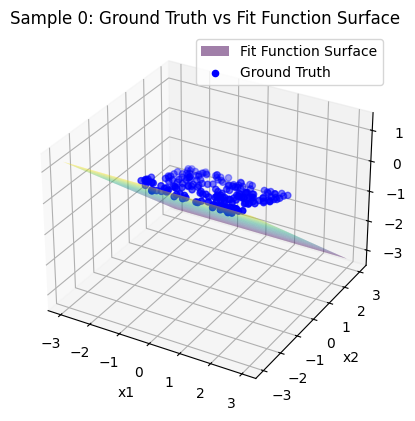

Sampled sequence 1: tensor([ 1,  4,  4, 18,  7, 10,  7,  4,  5,  2,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C C x2 * sin * C +
Parsed RPN (indices): [np.int64(4), np.int64(4), np.int64(18), np.int64(7), np.int64(10), np.int64(7), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 3
Parsed RPN (tokens): C C x2 * sin * C +
Optimizing 3 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): True
  Message (DE): Optimization terminated successfully.
  Final Loss: 0.000000
  Fitted Constants: [-2.0134933  -0.44251105 -1.6758319 ]
  Number of function evaluations (NFEV): 3424


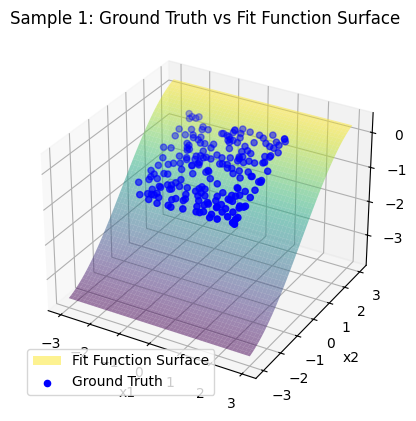

Sampled sequence 2: tensor([ 1,  4,  4, 18,  7,  4,  5, 10,  7,  4,  5,  2,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C C x2 * C + sin * C +
Parsed RPN (indices): [np.int64(4), np.int64(4), np.int64(18), np.int64(7), np.int64(4), np.int64(5), np.int64(10), np.int64(7), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 4
Parsed RPN (tokens): C C x2 * C + sin * C +
Optimizing 4 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): False
  Message (DE): Maximum number of iterations has been exceeded.
  Final Loss: 0.000000
  Fitted Constants: [-1.8056222  -0.62147564 -1.2630891   1.0799611 ]
  Number of function evaluations (NFEV): 6080


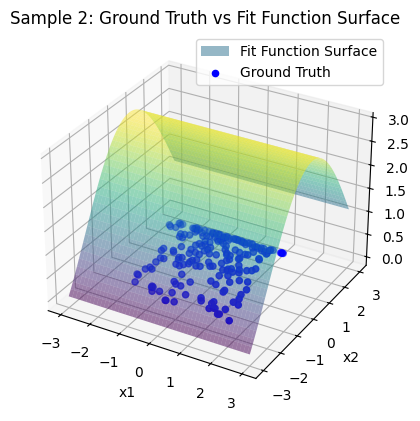

Sampled sequence 3: tensor([ 1,  4, 17, 15,  9,  7,  4,  5,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C x1 2 ** * C +
Parsed RPN (indices): [np.int64(4), np.int64(17), np.int64(15), np.int64(9), np.int64(7), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 2
Parsed RPN (tokens): C x1 2 ** * C +
Optimizing 2 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): True
  Message (DE): Optimization terminated successfully.
  Final Loss: 0.000000
  Fitted Constants: [1.3108733  0.35199228]
  Number of function evaluations (NFEV): 1233


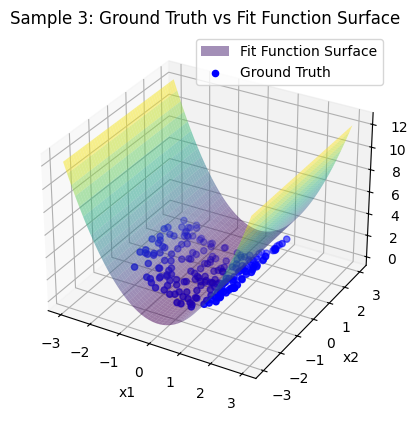

Sampled sequence 4: tensor([ 1,  4, 17,  7,  4, 18,  7,  5,  4,  4, 17,  7, 10,  7,  5,  4,  4, 17,
         7,  4,  5, 10,  7,  5,  4,  5,  2,  0,  0,  0], device='cuda:0')
Ground Truth C x1 * C C x2 * C + cos * + C +
Parsed RPN (indices): [np.int64(4), np.int64(17), np.int64(7), np.int64(4), np.int64(18), np.int64(7), np.int64(5), np.int64(4), np.int64(4), np.int64(17), np.int64(7), np.int64(10), np.int64(7), np.int64(5), np.int64(4), np.int64(4), np.int64(17), np.int64(7), np.int64(4), np.int64(5), np.int64(10), np.int64(7), np.int64(5), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 8
Parsed RPN (tokens): C x1 * C x2 * + C C x1 * sin * + C C x1 * C + sin * + C +
Optimizing 8 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): True
  Message (DE): Optimization terminated successfully.
  Final Loss: 0.008536
  Fitted Constants: [ 2.0829997  -0.33338752  0.92613894 -0.2561712   0.02201466  5.5785446
 -4.5509896  -0.19504564]
  Number of func

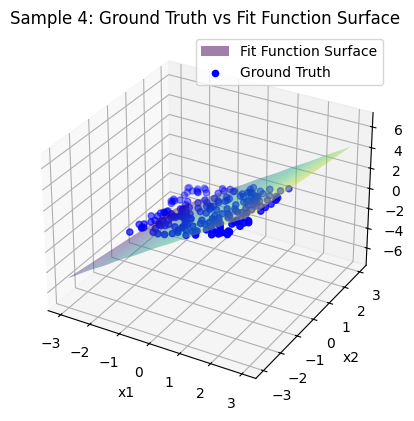

Sampled sequence 5: tensor([ 1,  4, 17,  7,  4,  7,  4, 17,  7, 13,  7,  4, 18,  7,  5,  4,  5,  2,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C x1 * C * C x1 * log * C x2 * + C +
Parsed RPN (indices): [np.int64(4), np.int64(17), np.int64(7), np.int64(4), np.int64(7), np.int64(4), np.int64(17), np.int64(7), np.int64(13), np.int64(7), np.int64(4), np.int64(18), np.int64(7), np.int64(5), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 5
Parsed RPN (tokens): C x1 * C * C x1 * log * C x2 * + C +
Optimizing 5 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): False
  Message (DE): Maximum number of iterations has been exceeded.
  Final Loss: 0.000000
  Fitted Constants: [-0.55455095 -0.513454   -1.2051479  -0.571306   -0.5214878 ]
  Number of function evaluations (NFEV): 7593


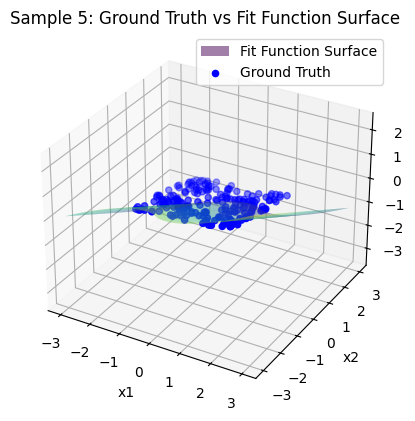

Sampled sequence 6: tensor([ 1,  4,  4, 17,  7,  4,  5, 13,  7,  4,  7,  4, 17,  7,  4,  5, 10,  7,
         4,  5,  2,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C C C C x1 * C + log * cos * exp * C +
Parsed RPN (indices): [np.int64(4), np.int64(4), np.int64(17), np.int64(7), np.int64(4), np.int64(5), np.int64(13), np.int64(7), np.int64(4), np.int64(7), np.int64(4), np.int64(17), np.int64(7), np.int64(4), np.int64(5), np.int64(10), np.int64(7), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 7
Parsed RPN (tokens): C C x1 * C + log * C * C x1 * C + sin * C +
Optimizing 7 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): False
  Message (DE): Maximum number of iterations has been exceeded.
  Final Loss: 0.127880
  Fitted Constants: [-0.24231397  5.894456    5.7317944   0.82875746 -0.6785348  -5.8440714
 -0.77024406]
  Number of function evaluations (NFEV): 10613


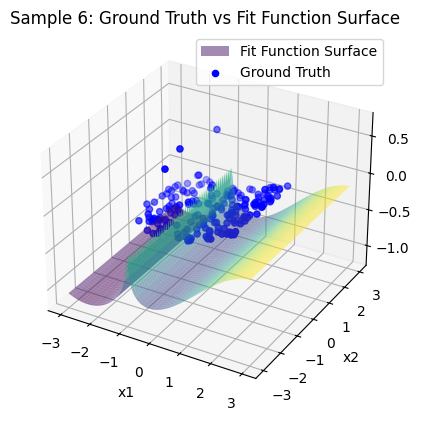

Sampled sequence 7: tensor([ 1,  4,  4, 17,  7, 10,  7,  4,  5,  2,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C C x1 * C + sin * C +
Parsed RPN (indices): [np.int64(4), np.int64(4), np.int64(17), np.int64(7), np.int64(10), np.int64(7), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 3
Parsed RPN (tokens): C C x1 * sin * C +
Optimizing 3 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): True
  Message (DE): Optimization terminated successfully.
  Final Loss: 0.107915
  Fitted Constants: [1.7567084  1.9755538  0.45547095]
  Number of function evaluations (NFEV): 1174


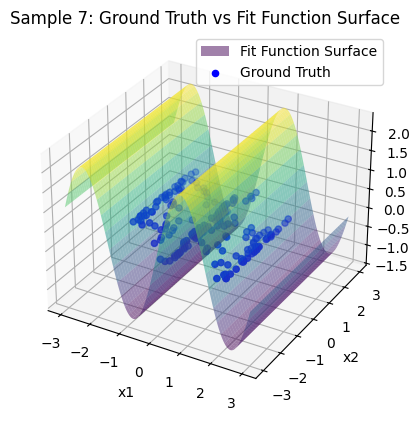

Sampled sequence 8: tensor([ 1,  4, 18,  7,  4,  4, 18,  7, 10,  7,  5,  4,  5,  2,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C C C x2 * sin * sin * C +
Parsed RPN (indices): [np.int64(4), np.int64(18), np.int64(7), np.int64(4), np.int64(4), np.int64(18), np.int64(7), np.int64(10), np.int64(7), np.int64(5), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 4
Parsed RPN (tokens): C x2 * C C x2 * sin * + C +
Optimizing 4 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): True
  Message (DE): Optimization terminated successfully.
  Final Loss: 0.009106
  Fitted Constants: [ 0.51622975 -0.46878785 -1.680797   -1.8406117 ]
  Number of function evaluations (NFEV): 2605


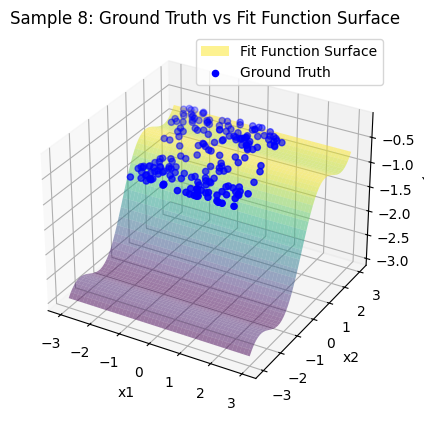

Sampled sequence 9: tensor([ 1,  4,  4, 17,  7, 12,  7,  4,  7,  4, 17,  7,  4,  5, 11,  7,  4,  5,
         2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C C x1 * exp * C +
Parsed RPN (indices): [np.int64(4), np.int64(4), np.int64(17), np.int64(7), np.int64(12), np.int64(7), np.int64(4), np.int64(7), np.int64(4), np.int64(17), np.int64(7), np.int64(4), np.int64(5), np.int64(11), np.int64(7), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 6
Parsed RPN (tokens): C C x1 * exp * C * C x1 * C + cos * C +
Optimizing 6 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): False
  Message (DE): Maximum number of iterations has been exceeded.
  Final Loss: 0.123134
  Fitted Constants: [-2.2800674 -0.5725469 -1.3459533  0.2658151 -1.5816302 -1.0660424]
  Number of function evaluations (NFEV): 9097


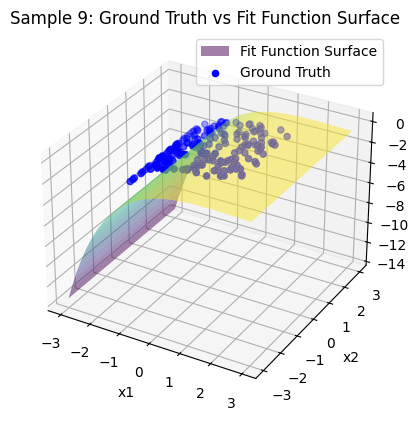

Sampled sequence 10: tensor([ 1,  4,  4, 17,  7,  4,  5, 13,  7,  4,  5,  2,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C C x1 * C + log * C +
Parsed RPN (indices): [np.int64(4), np.int64(4), np.int64(17), np.int64(7), np.int64(4), np.int64(5), np.int64(13), np.int64(7), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 4
Parsed RPN (tokens): C C x1 * C + log * C +
Optimizing 4 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): False
  Message (DE): Maximum number of iterations has been exceeded.
  Final Loss: 0.000000
  Fitted Constants: [-1.6657089  7.7146063  6.969423   5.5772967]
  Number of function evaluations (NFEV): 6065


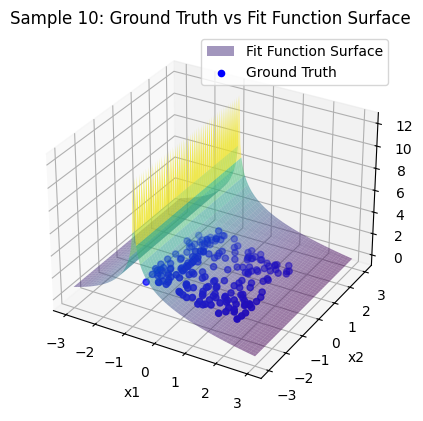

Sampled sequence 11: tensor([ 1,  4, 17,  7,  4, 18,  7,  5,  4,  4, 17,  7,  4,  5, 13,  7,  5,  4,
         4, 18,  7, 11,  7,  5,  4,  5,  2,  0,  0,  0], device='cuda:0')
Ground Truth C x1 * C x2 * + C +
Parsed RPN (indices): [np.int64(4), np.int64(17), np.int64(7), np.int64(4), np.int64(18), np.int64(7), np.int64(5), np.int64(4), np.int64(4), np.int64(17), np.int64(7), np.int64(4), np.int64(5), np.int64(13), np.int64(7), np.int64(5), np.int64(4), np.int64(4), np.int64(18), np.int64(7), np.int64(11), np.int64(7), np.int64(5), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 8
Parsed RPN (tokens): C x1 * C x2 * + C C x1 * C + log * + C C x2 * cos * + C +
Optimizing 8 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): False
  Message (DE): Maximum number of iterations has been exceeded.
  Final Loss: 0.000000
  Fitted Constants: [ 1.6125059e+00 -1.2660064e+00 -3.4451368e-06  2.8953469e-01
 -8.2442675e+00  2.7919179e-04 -2.6119599e-01 -2.0934

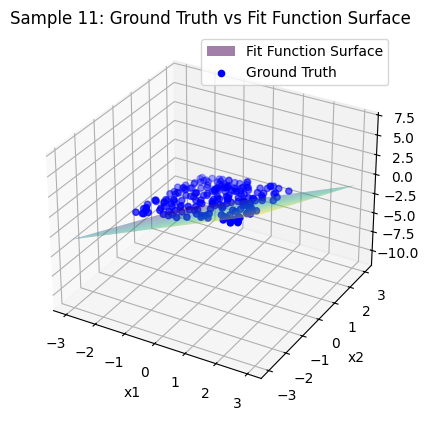

Sampled sequence 12: tensor([ 1,  4, 17,  7,  4,  4, 17,  7,  4,  5, 10,  7,  5,  4,  5,  2,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C x1 * C C x1 * sin * + C +
Parsed RPN (indices): [np.int64(4), np.int64(17), np.int64(7), np.int64(4), np.int64(4), np.int64(17), np.int64(7), np.int64(4), np.int64(5), np.int64(10), np.int64(7), np.int64(5), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 5
Parsed RPN (tokens): C x1 * C C x1 * C + sin * + C +
Optimizing 5 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): False
  Message (DE): Maximum number of iterations has been exceeded.
  Final Loss: 0.000183
  Fitted Constants: [ 0.9081122  -0.943035   -0.92945623  0.0084658   0.8060854 ]
  Number of function evaluations (NFEV): 7707


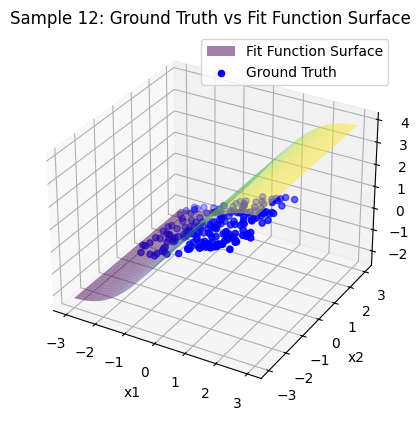

Sampled sequence 13: tensor([ 1,  4, 17,  7,  4,  4, 18,  7,  4,  5, 11,  7,  5,  4,  5,  2,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C x1 2 ** * C * C x2 * C + sin * C x1 * + C +
Parsed RPN (indices): [np.int64(4), np.int64(17), np.int64(7), np.int64(4), np.int64(4), np.int64(18), np.int64(7), np.int64(4), np.int64(5), np.int64(11), np.int64(7), np.int64(5), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 5
Parsed RPN (tokens): C x1 * C C x2 * C + cos * + C +
Optimizing 5 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): True
  Message (DE): Optimization terminated successfully.
  Final Loss: 0.020748
  Fitted Constants: [-1.326536   -0.12445258  0.9037109   3.309266   -1.8469262 ]
  Number of function evaluations (NFEV): 4365


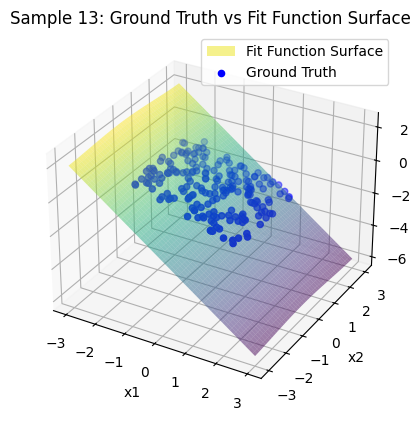

Sampled sequence 14: tensor([ 1,  4,  4,  4, 18,  7, 12,  7, 11,  7,  4,  5,  2,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C C C x2 * exp * cos * C +
Parsed RPN (indices): [np.int64(4), np.int64(4), np.int64(4), np.int64(18), np.int64(7), np.int64(12), np.int64(7), np.int64(11), np.int64(7), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 4
Parsed RPN (tokens): C C C x2 * exp * cos * C +
Optimizing 4 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): False
  Message (DE): Maximum number of iterations has been exceeded.
  Final Loss: 0.000000
  Fitted Constants: [-1.3600405  -0.5152082   1.1381948  -0.44671094]
  Number of function evaluations (NFEV): 6080


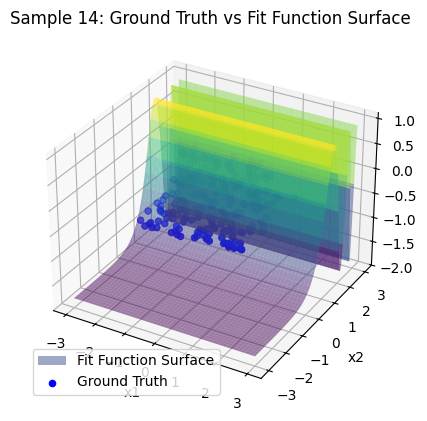

Sampled sequence 15: tensor([ 1,  4,  4, 18,  7, 12,  7,  4,  7,  4, 17,  7,  4,  5, 10,  7,  4,  5,
         2,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C C x2 * exp * C * C x1 * cos * C +
Parsed RPN (indices): [np.int64(4), np.int64(4), np.int64(18), np.int64(7), np.int64(12), np.int64(7), np.int64(4), np.int64(7), np.int64(4), np.int64(17), np.int64(7), np.int64(4), np.int64(5), np.int64(10), np.int64(7), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 6
Parsed RPN (tokens): C C x2 * exp * C * C x1 * C + sin * C +
Optimizing 6 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): False
  Message (DE): Maximum number of iterations has been exceeded.
  Final Loss: 0.307983
  Fitted Constants: [ 0.13661936 -1.8777084  -0.561742   -1.3565379   7.950067    1.9025092 ]
  Number of function evaluations (NFEV): 9097


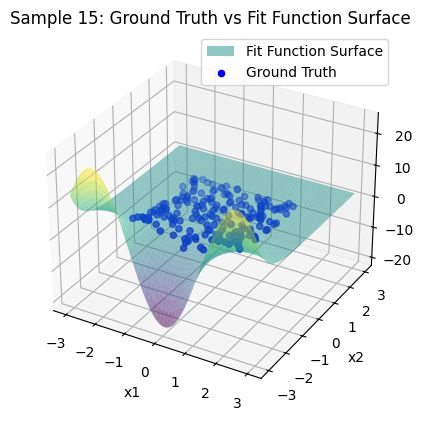

Sampled sequence 16: tensor([ 1,  4, 17,  7,  4,  4, 17,  7, 12,  7,  5,  4,  5,  2,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C C x1 * exp * C +
Parsed RPN (indices): [np.int64(4), np.int64(17), np.int64(7), np.int64(4), np.int64(4), np.int64(17), np.int64(7), np.int64(12), np.int64(7), np.int64(5), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 4
Parsed RPN (tokens): C x1 * C C x1 * exp * + C +
Optimizing 4 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): True
  Message (DE): Optimization terminated successfully.
  Final Loss: 0.254317
  Fitted Constants: [-3.5459661  9.927752   0.2454794 -9.983527 ]
  Number of function evaluations (NFEV): 4565


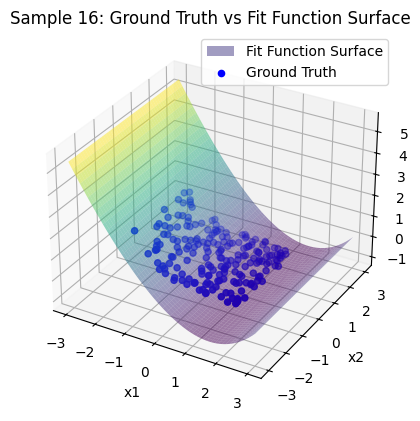

Sampled sequence 17: tensor([ 1,  4,  4,  4,  4, 17,  7, 12,  7, 10,  7, 12,  7,  4,  5,  2,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C C C x2 * C + cos * cos * C +
Parsed RPN (indices): [np.int64(4), np.int64(4), np.int64(4), np.int64(4), np.int64(17), np.int64(7), np.int64(12), np.int64(7), np.int64(10), np.int64(7), np.int64(12), np.int64(7), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 5
Parsed RPN (tokens): C C C C x1 * exp * sin * exp * C +
Optimizing 5 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): True
  Message (DE): Optimization terminated successfully.
  Final Loss: 0.000012
  Fitted Constants: [ 0.01151032 -0.13020536  3.4622126  -4.595355   -1.077703  ]
  Number of function evaluations (NFEV): 4287


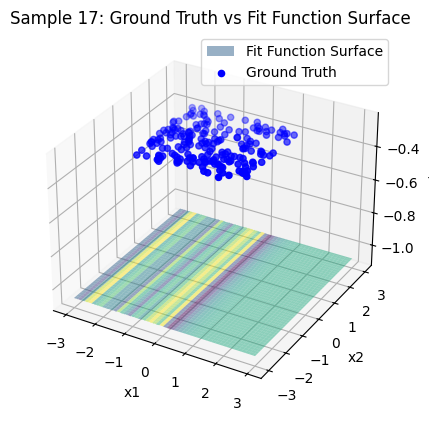

Sampled sequence 18: tensor([ 1,  4,  4,  4, 18,  7, 13,  7, 11,  7,  4,  5,  2,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C C C x2 * log * sin * C +
Parsed RPN (indices): [np.int64(4), np.int64(4), np.int64(4), np.int64(18), np.int64(7), np.int64(13), np.int64(7), np.int64(11), np.int64(7), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 4
Parsed RPN (tokens): C C C x2 * log * cos * C +
Optimizing 4 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): True
  Message (DE): Optimization terminated successfully.
  Final Loss: 0.000000
  Fitted Constants: [ 1.2075559 -1.0300739  5.7009735  1.5948386]
  Number of function evaluations (NFEV): 5825


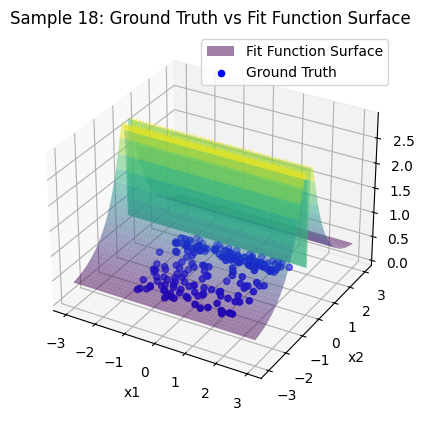

Sampled sequence 19: tensor([ 1,  4,  4, 17,  7,  4, 18,  7,  5,  4,  5, 11,  7,  4,  5,  2,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
Ground Truth C C x1 * C x2 * + cos * C +
Parsed RPN (indices): [np.int64(4), np.int64(4), np.int64(17), np.int64(7), np.int64(4), np.int64(18), np.int64(7), np.int64(5), np.int64(4), np.int64(5), np.int64(11), np.int64(7), np.int64(4), np.int64(5)]
Number of constants 'C' to fit: 5
Parsed RPN (tokens): C C x1 * C x2 * + C + cos * C +
Optimizing 5 constants with DE (JITted loss, workers=1)...
Optimization finished.
  Success (DE): False
  Message (DE): Maximum number of iterations has been exceeded.
  Final Loss: 0.000000
  Fitted Constants: [-1.4909836  1.0249059  1.0692858  6.2832456  1.5289419]
  Number of function evaluations (NFEV): 7581


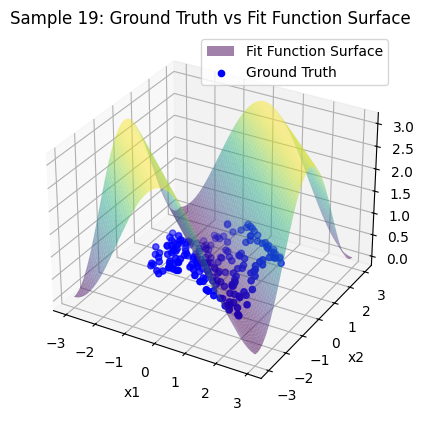

In [ ]:
vocab = {
    "<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3, "C": 4, "+": 5, "-": 6,
    "*": 7, "/": 8, "**": 9, "sin": 10, "cos": 11, "exp": 12, "log": 13,
    "2": 15, "3": 16, "x1": 17, "x2": 18
}

for i in range(batch_condition_size):
    print(f"Sampled sequence {i}:", samples[i])
    print("Ground Truth", data[i]["RPN"])
    predictor_function = create_rpn_fitting_function(samples[i], vocab, denormed_data[i]["X_Y_combined"])
    
    import matplotlib.pyplot as plt

    # Extract X and Y_true from the batch_condition and ground truth for this sample
    X = np.array(batch_conditions[i])[:, :2]  # shape (N, 2)
    Y_true = np.array([row[-1] for row in batch_conditions[i]])  # shape (N,)

    # Predict Y values at the original points using the fit function
    Y_pred = predictor_function(X)
    Y_pred = np.array(Y_pred)

    # Create a meshgrid for x1 and x2
    x1_lin = np.linspace(-3, 3, 150)
    x2_lin = np.linspace(-3, 3, 150)
    X1_grid, X2_grid = np.meshgrid(x1_lin, x2_lin)
    X_mesh = np.stack([X1_grid.ravel(), X2_grid.ravel()], axis=1)

    # Predict Y values on the meshgrid using the fit function
    Y_mesh_pred = predictor_function(X_mesh)
    Y_mesh_pred = np.array(Y_mesh_pred).reshape(X1_grid.shape)

    # Plot the surface
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X1_grid, X2_grid, Y_mesh_pred, alpha=0.5, cmap='viridis', label='Fit Function Surface')
    ax.scatter(X[:, 0], X[:, 1], Y_true, label='Ground Truth', color='blue')
    #ax.scatter(X[:, 0], X[:, 1], Y_pred, label='Fit Function (Points)', color='red', marker='^')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_zlabel('Y')
    ax.legend()
    plt.title(f'Sample {i}: Ground Truth vs Fit Function Surface')
    plt.show()

In [ ]:
print(data[0]["X_Y_combined"])

[[-1.3243833780288696, -0.9479379057884216, 0.05687294900417328], [0.32566604018211365, 0.9103389382362366, -0.523749589920044], [-1.38998281955719, -0.9145170450210571, 0.04643053188920021], [-1.0462185144424438, 0.9894763827323914, -0.5484762787818909], [1.6917665004730225, 1.089860200881958, -0.5798414349555969], [-1.1142394542694092, 0.12739507853984833, -0.2791171371936798], [0.3983113169670105, -0.7646333575248718, -0.00040094670839607716], [-1.1931333541870117, -0.10657405108213425, -0.20601297914981842], [-0.32735252380371094, 1.2363804578781128, -0.6256219744682312], [-1.0817798376083374, 0.7076578736305237, -0.46042147278785706], [-0.09660004079341888, -1.2755218744277954, 0.15922726690769196], [1.3705840110778809, 1.4054832458496094, -0.6784585118293762], [1.1717991828918457, 0.38645321130752563, -0.3600603938102722], [1.5943186283111572, 0.596189558506012, -0.42559298872947693], [-0.5453105568885803, -0.30448153614997864, -0.14417637884616852], [0.19883288443088531, -0.5778